In [1]:
from __future__ import print_function

import time
from PIL import Image
import numpy as np

from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave

Using TensorFlow backend.


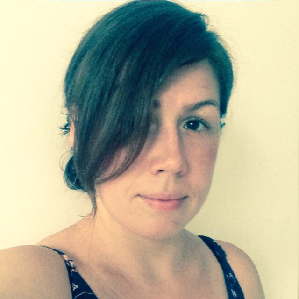

In [69]:
height = 299
width = 299

content_image_path = 'data/style/IMG_0272.jpg'
content_image = Image.open(content_image_path)
content_image = content_image.resize((height, width))
content_image

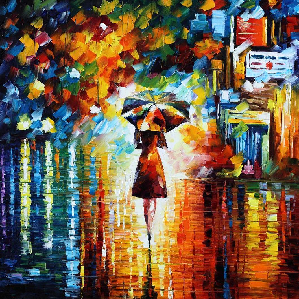

In [70]:
style_image_path = 'data/style/mask/rain_princess.jpg'
style_image = Image.open(style_image_path)
style_image = style_image.resize((height, width))
style_image

In [71]:
content_array = np.asarray(content_image, dtype='float32')
content_array = np.expand_dims(content_array, axis=0)
print(content_array.shape)

style_array = np.asarray(style_image, dtype='float32')
style_array = np.expand_dims(style_array, axis=0)
print(style_array.shape)

(1, 299, 299, 3)
(1, 299, 299, 3)


In [72]:
content_array[:, :, :, 0] -= 103.939
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68
content_array = content_array[:, :, :, ::-1]

style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68
style_array = style_array[:, :, :, ::-1]

In [73]:
content_image = backend.variable(content_array)
style_image = backend.variable(style_array)
combination_image = backend.placeholder((1, height, width, 3))

In [74]:
input_tensor = backend.concatenate([content_image,
                                    style_image,
                                    combination_image], axis=0)

In [75]:
model = VGG16(input_tensor=input_tensor, weights='imagenet',
              include_top=False)

In [76]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [77]:
layers = dict([(layer.name, layer.output) for layer in model.layers])
layers

{'block1_conv1': <tf.Tensor 'block1_conv1_3/Relu:0' shape=(3, 299, 299, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2_3/Relu:0' shape=(3, 299, 299, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool_3/MaxPool:0' shape=(3, 149, 149, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1_3/Relu:0' shape=(3, 149, 149, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2_3/Relu:0' shape=(3, 149, 149, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool_3/MaxPool:0' shape=(3, 74, 74, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1_3/Relu:0' shape=(3, 74, 74, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2_3/Relu:0' shape=(3, 74, 74, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3_3/Relu:0' shape=(3, 74, 74, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool_3/MaxPool:0' shape=(3, 37, 37, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'block4_conv1_3/Relu:0' shape=(3, 37, 37, 512) dtype

The crux of the paper we're trying to reproduce is that the style transfer problem can be posed as an optimisation problem, where the loss function we want to minimise can be decomposed into three distinct parts: the content loss, the style loss and the total variation loss.
The relative importance of these terms are determined by a set of scalar weights. These are arbitrary, but the following set have been chosen after quite a bit of experimentation to find a set that generates output that's aesthetically pleasing to me.

In [78]:
content_weight = 0.025
style_weight = 5.0
total_variation_weight = 1.0

In [79]:
loss = backend.variable(0.)

The content loss is the (scaled, squared) Euclidean distance between feature representations of the content and combination images.

In [80]:
def content_loss(content, combination):
    return backend.sum(backend.square(combination - content))

layer_features = layers['block2_conv2']
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

loss += content_weight * content_loss(content_image_features,
                                      combination_features)

# The style loss
This is where things start to get a bit intricate.
For the style loss, we first define something called a Gram matrix. The terms of this matrix are proportional to the covariances of corresponding sets of features, and thus captures information about which features tend to activate together. By only capturing these aggregate statistics across the image, they are blind to the specific arrangement of objects inside the image. This is what allows them to capture information about style independent of content. (This is not trivial at all, and I refer you to a paper that attempts to explain the idea.)
The Gram matrix can be computed efficiently by reshaping the feature spaces suitably and taking an outer product.

In [81]:
def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram

The style loss is then the (scaled, squared) Frobenius norm of the difference between the Gram matrices of the style and combination images.
Again, in the following code, I've chosen to go with the style features from layers defined in Johnson et al. (2016) rather than Gatys et al. (2015) because I find the end results more aesthetically pleasing. I encourage you to experiment with these choices to see varying results.

In [82]:
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = height * width
    return backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']
for layer_name in feature_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_features, combination_features)
    loss += (style_weight / len(feature_layers)) * sl

#The total variation loss

Now we're back on simpler ground.
If you were to solve the optimisation problem with only the two loss terms we've introduced so far (style and content), you'll find that the output is quite noisy. We thus add another term, called the total variation loss (a regularisation term) that encourages spatial smoothness.
You can experiment with reducing the total_variation_weight and play with the noise-level of the generated image.

In [83]:
def total_variation_loss(x):
    a = backend.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))

loss += total_variation_weight * total_variation_loss(combination_image)

# Define needed gradients and solve the optimisation problem
The goal of this journey was to setup an optimisation problem that aims to solve for a combination image that contains the content of the content image, while having the style of the style image. Now that we have our input images massaged and our loss function calculators in place, all we have left to do is define gradients of the total loss relative to the combination image, and use these gradients to iteratively improve upon our combination image to minimise the loss.
We start by defining the gradients.

In [84]:
grads = backend.gradients(loss, combination_image)

We then introduce an Evaluator class that computes loss and gradients in one pass while retrieving them via two separate functions, loss and grads. This is done because scipy.optimize requires separate functions for loss and gradients, but computing them separately would be inefficient.

In [85]:
outputs = [loss]
outputs += grads
f_outputs = backend.function([combination_image], outputs)

def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

Now we're finally ready to solve our optimisation problem. This combination image begins its life as a random collection of (valid) pixels, and we use the L-BFGS algorithm (a quasi-Newton algorithm that's significantly quicker to converge than standard gradient descent) to iteratively improve upon it.
We stop after 10 iterations because the output looks good to me and the loss stops reducing significantly.

In [86]:
x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.

iterations = 17

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 1.31688e+11
Iteration 0 completed in 241s
Start of iteration 1
Current loss value: 6.87546e+10
Iteration 1 completed in 220s
Start of iteration 2
Current loss value: 5.26624e+10
Iteration 2 completed in 221s
Start of iteration 3
Current loss value: 4.6864e+10
Iteration 3 completed in 216s
Start of iteration 4
Current loss value: 4.36069e+10
Iteration 4 completed in 214s
Start of iteration 5
Current loss value: 4.12153e+10
Iteration 5 completed in 214s
Start of iteration 6
Current loss value: 3.98374e+10
Iteration 6 completed in 214s
Start of iteration 7
Current loss value: 3.89526e+10
Iteration 7 completed in 214s
Start of iteration 8
Current loss value: 3.78969e+10
Iteration 8 completed in 214s
Start of iteration 9
Current loss value: 3.71334e+10
Iteration 9 completed in 214s
Start of iteration 10
Current loss value: 3.66653e+10
Iteration 10 completed in 214s
Start of iteration 11
Current loss value: 3.61465e+10
Iteration 11 completed in 214s
S

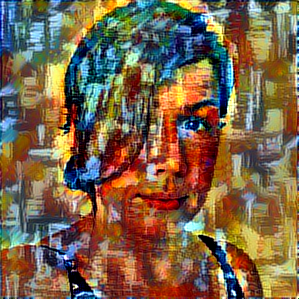

In [87]:
x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')

Image.fromarray(x)